Train dataset contains real and simulated coordinates and velocities for 600 satellites, for one month. 

Test dataset contains only simulated coordinates and velocities for 300 of the satellites from train dataset, for the next month. 

Participants should predict real coordinates and velocities for these 300 satellites.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns

from time import time
from datetime import datetime 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
import xgboost as xgb
from catboost  import CatBoostRegressor

In [2]:
train = pd.read_csv(r'D:\Загрузки\IDAO 2020\train.csv')
test = pd.read_csv(r'D:\Загрузки\IDAO 2020\Track 1\test.csv')

In [3]:
train.head(3)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


In [4]:
test.head(2)

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402


In [5]:
train = train.drop('id', axis=1)

In [6]:
len(train.loc[:,'sat_id'].unique())

600

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649912 entries, 0 to 649911
Data columns (total 14 columns):
epoch     649912 non-null object
sat_id    649912 non-null int64
x         649912 non-null float64
y         649912 non-null float64
z         649912 non-null float64
Vx        649912 non-null float64
Vy        649912 non-null float64
Vz        649912 non-null float64
x_sim     649912 non-null float64
y_sim     649912 non-null float64
z_sim     649912 non-null float64
Vx_sim    649912 non-null float64
Vy_sim    649912 non-null float64
Vz_sim    649912 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 69.4+ MB


In [8]:
train.describe()

,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
count,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000
mean,308.730351,-817.243624,423.039342,-75.033412,-0.000571,0.000468,-0.000084,-949.710660,324.557198,-79.766677,-0.000519,0.000394,-0.000312
std,171.482926,25391.507810,25631.511540,20652.050496,2.639041,2.597130,2.116245,25374.076264,25607.472371,20667.988715,2.637491,2.600323,2.113769
min,0.000000,-251938.766780,-291083.016974,-178922.412426,-8.286673,-8.231654,-9.371164,-255037.952966,-282851.387908,-180250.922287,-8.243159,-8.348831,-7.671565
25%,166.000000,-13127.557237,-11620.365836,-8000.289962,-1.892727,-1.874982,-1.255991,-13153.145398,-11736.509125,-7956.446370,-1.896259,-1.877142,-1.246751
50%,312.000000,-506.673520,514.039628,45.175018,0.019951,-0.051700,0.009385,-623.114440,523.437227,56.891526,0.021274,-0.012901,0.012037
75%,461.000000,11318.543144,12614.274408,8279.083423,1.960031,1.845111,1.237103,11190.022140,12547.532119,8235.078108,1.955522,1.862365,1.236030
max,599.000000,200382.689756,212443.393808,197200.530574,8.149559,12.308450,8.644558,200961.158000,209619.553857,198526.091552,7.431851,8.021438,8.644165


In [9]:
train.columns

Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim',
       'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'],
      dtype='object')

In [10]:
train_real = train.loc[:, ['epoch','sat_id','x','y','z','Vx','Vy','Vz']]
train_sim = train.loc[:, ['epoch','sat_id','x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']]

In [11]:
print(train_real.columns)
print(train_sim.columns)

Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz'], dtype='object')
Index(['epoch', 'sat_id', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim',
       'Vz_sim'],
      dtype='object')


## Попробуем посмтроить графики координат для реал и предиктов 

![title](coordinates.png)

In [12]:
coord_real = train_real[train_real['sat_id'] == 0].loc[:, ['x','y','z']]
coord_sim = train_sim[train_sim['sat_id'] == 0].loc[:, ['x_sim','y_sim','z_sim']]

In [13]:
print('observ number:', train_real[train_real['sat_id'] == 0].shape[0])

observ number: 958


(-50000, 50000)

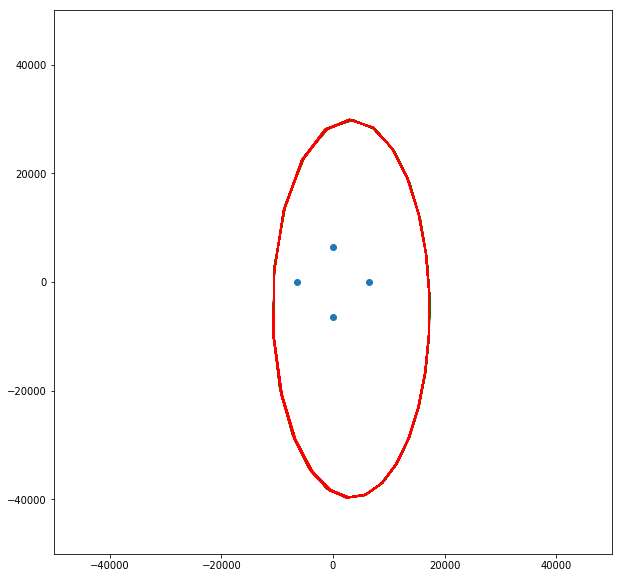

In [14]:
ax = plt.figure(figsize=(10,10))
plt.scatter([-6371,6371,0,0], [0,0,-6371,6371])
plt.plot(coord_real.loc[:,'x'], coord_real.loc[:,'y'], 'g')
plt.plot(coord_sim.loc[:,'x_sim'], coord_sim.loc[:,'y_sim'], 'r')
plt.xlim(-50000, 50000)
plt.ylim(-50000, 50000)

(-50000, 50000)

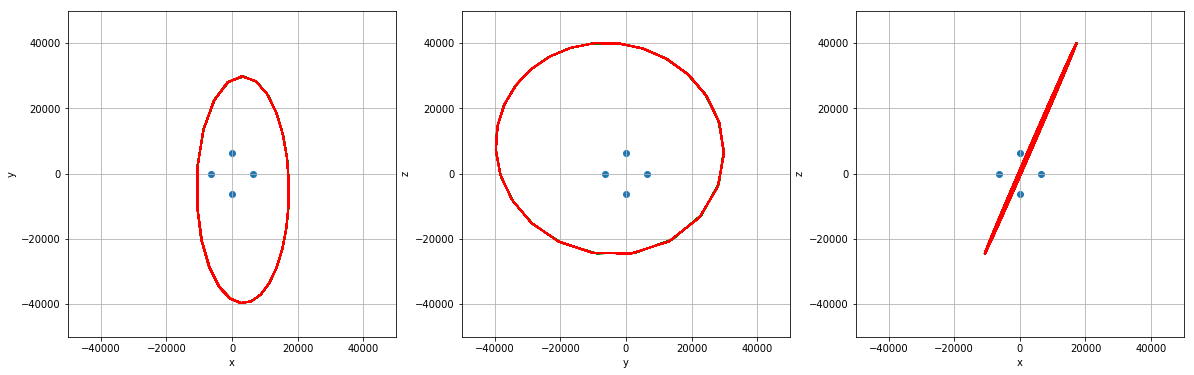

In [15]:
# plot example
# точками обозначена Земля
plt.figure(figsize=(20, 6))

ax1 = plt.subplot(131)
plt.grid()
plt.scatter([-6371,6371,0,0], [0,0,-6371,6371])
plt.plot(coord_real.loc[:,'x'], coord_real.loc[:,'y'], 'g')
plt.plot(coord_sim.loc[:,'x_sim'], coord_sim.loc[:,'y_sim'], 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-50000, 50000)
plt.ylim(-50000, 50000)

ax2 = plt.subplot(132, sharex=ax1, sharey=ax1)
plt.grid()
plt.scatter([-6371,6371,0,0], [0,0,-6371,6371])
plt.plot(coord_real.loc[:,'y'], coord_real.loc[:,'z'], 'g')
plt.plot(coord_sim.loc[:,'y_sim'], coord_sim.loc[:,'z_sim'], 'r')
plt.xlabel('y')
plt.ylabel('z')
plt.xlim(-50000, 50000)
plt.ylim(-50000, 50000)

ax3 = plt.subplot(133, sharex=ax1, sharey=ax1)
plt.grid()
plt.scatter([-6371,6371,0,0], [0,0,-6371,6371])
plt.plot(coord_real.loc[:,'x'], coord_real.loc[:,'z'], 'g')
plt.plot(coord_sim.loc[:,'x_sim'], coord_sim.loc[:,'z_sim'], 'r')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim(-50000, 50000)
plt.ylim(-50000, 50000)

Если присмотреться, то видно, что предикты смещены

In [19]:
diff = pd.DataFrame({'x':np.subtract(coord_real.loc[:,'x'],coord_sim.loc[:,'x_sim']),
                     'y':np.subtract(coord_real.loc[:,'y'],coord_sim.loc[:,'y_sim']),
                     'z':np.subtract(coord_real.loc[:,'z'],coord_sim.loc[:,'z_sim'])})

In [20]:
diff.head(5)

,x,y,z
0,-12.692409,-20.441543,13.262073
1,-12.172318,-29.543301,21.276285
2,-6.825572,-34.527552,32.888826
3,1.368937,-33.237259,44.637815
4,10.266521,-26.790192,53.492019


In [21]:
diff = np.abs(diff)
diff.head()

,x,y,z
0,12.692409,20.441543,13.262073
1,12.172318,29.543301,21.276285
2,6.825572,34.527552,32.888826
3,1.368937,33.237259,44.637815
4,10.266521,26.790192,53.492019


In [22]:
diff.tail()

,x,y,z
953,1911.918388,15612.075013,4879.299912
954,3429.845937,14789.698343,8355.689969
955,5005.320639,13066.730924,11936.165799
956,6572.080659,10195.884818,15459.066758
957,7990.429369,5889.747366,18591.737280


In [23]:
diff.describe()

,x,y,z
count,958.000000,958.000000,958.000000
mean,2195.813550,5436.462537,5065.499649
std,2120.704688,5305.448932,4900.420056
min,0.935108,0.019449,0.144493
25%,71.485954,198.433841,121.724188
50%,1918.363332,5037.648279,4222.863670
75%,3456.898622,7988.854995,8018.753990
max,9158.649797,24606.996844,20854.343912


Если учесть, что значения координат могут варьироваться от -250000 до + 200000, то норм

In [77]:
# график разностей координат по осям для реальных и симулированных данных
def plot_dif(n):
    plt.figure(figsize=(20, 6))
    
    ax1 = plt.subplot(131)
    coord_dif = np.abs(train[train['sat_id'] == n].loc[:, 'x'] - train[train['sat_id'] == n].loc[:, 'x_sim'])
    coord_range = train[train['sat_id'] == n].shape[0]
    plt.plot(list(range(0, coord_range)), np.array(coord_dif))
    plt.xlabel('estimation')
    plt.ylabel('x')
    
    ax1 = plt.subplot(132)
    coord_dif = np.abs(train[train['sat_id'] == n].loc[:, 'y'] - train[train['sat_id'] == n].loc[:, 'y_sim'])
    coord_range = train[train['sat_id'] == n].shape[0]
    plt.plot(list(range(0, coord_range)), np.array(coord_dif))
    plt.xlabel('estimation')
    plt.ylabel('y')
    
    ax1 = plt.subplot(133)
    coord_dif = np.abs(train[train['sat_id'] == n].loc[:, 'z'] - train[train['sat_id'] == n].loc[:, 'z_sim'])
    coord_range = train[train['sat_id'] == n].shape[0]
    plt.plot(list(range(0, coord_range)), np.array(coord_dif))
    plt.xlabel('estimation')
    plt.ylabel('z')

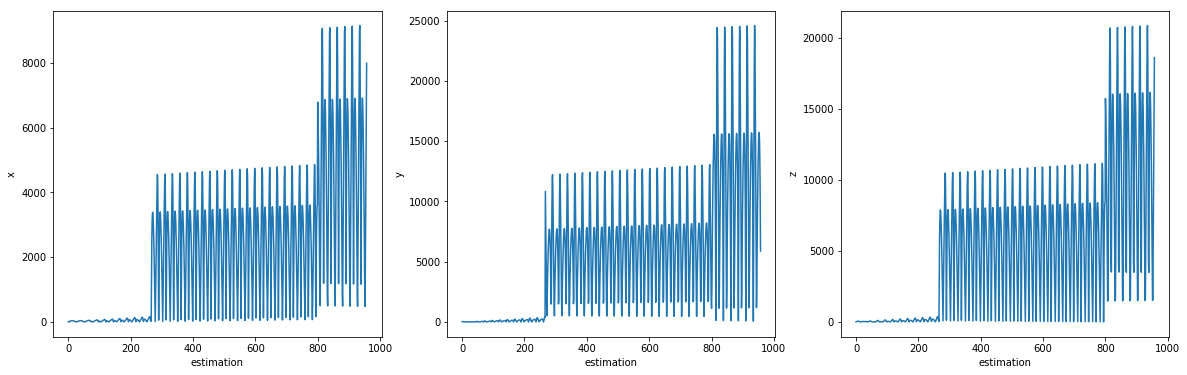

In [39]:
plot_dif(0)

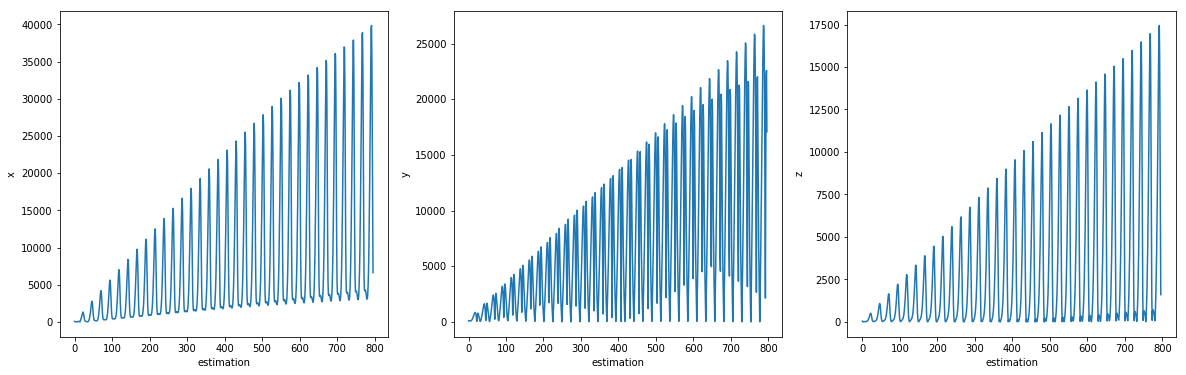

In [40]:
plot_dif(333)

In [74]:
# график разностей скоростей по осям для реальных и симулированных данных
def plot_Vaxis_dif(n):
    plt.figure(figsize=(20, 6))
    
    ax1 = plt.subplot(131)
    coord_dif = np.abs(train[train['sat_id'] == n].loc[:, 'Vx'] - train[train['sat_id'] == n].loc[:, 'Vx_sim'])
    coord_range = train[train['sat_id'] == n].shape[0]
    plt.plot(list(range(0, coord_range)), np.array(coord_dif))
    plt.xlabel('estimation')
    plt.ylabel('Vx')
    
    ax1 = plt.subplot(132)
    coord_dif = np.abs(train[train['sat_id'] == n].loc[:, 'Vy'] - train[train['sat_id'] == n].loc[:, 'Vy_sim'])
    coord_range = train[train['sat_id'] == n].shape[0]
    plt.plot(list(range(0, coord_range)), np.array(coord_dif))
    plt.xlabel('estimation')
    plt.ylabel('Vy')
    
    ax1 = plt.subplot(133)
    coord_dif = np.abs(train[train['sat_id'] == n].loc[:, 'Vz'] - train[train['sat_id'] == n].loc[:, 'Vz_sim'])
    coord_range = train[train['sat_id'] == n].shape[0]
    plt.plot(list(range(0, coord_range)), np.array(coord_dif))
    plt.xlabel('estimation')
    plt.ylabel('Vz')

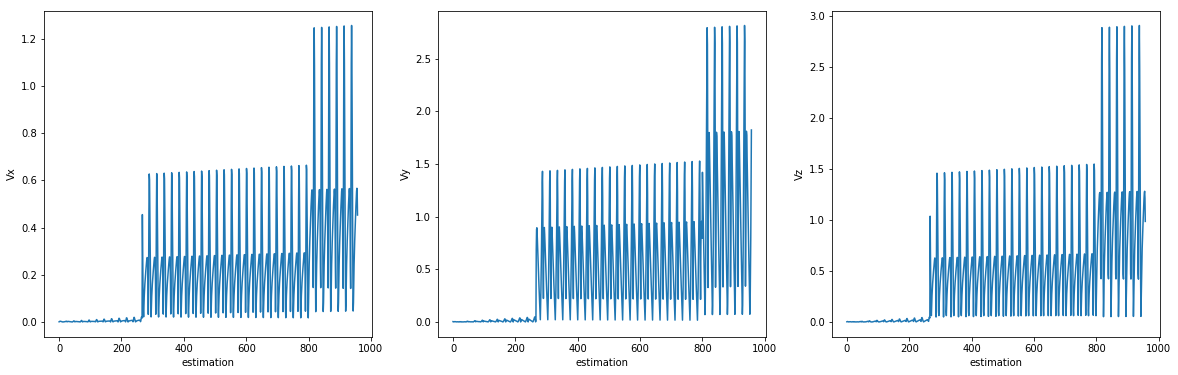

In [75]:
plot_Vaxis_dif(0)

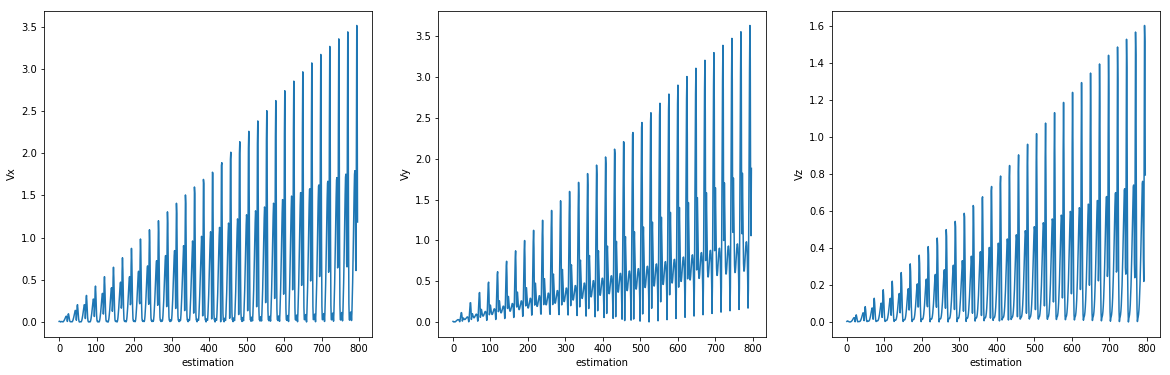

In [76]:
plot_Vaxis_dif(333)

### Метрика 

In [41]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values) 
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))

## Исправление ошибки SGP4 

In [220]:
train = pd.read_csv(r'D:\Загрузки\IDAO 2020\train.csv')
test = pd.read_csv(r'D:\Загрузки\IDAO 2020\Track 1\test.csv')

# train_real = train.loc[:, ['id', 'epoch','sat_id','x','y','z','Vx','Vy','Vz']]
# train_sim = train.loc[:, ['id', 'epoch','sat_id','x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']]

In [221]:
print(train.shape)
print(test.shape)
# print(train_real.shape)
# print(train_sim.shape)

(649912, 15)
(284071, 9)


#### Перевод эпохи в столбцы день, час, минут, секунд

Время наблюдений у нас только Январь 2014 года => изменения года, месяца не влияют

In [222]:
min(train.loc[:,'epoch'])

'2014-01-01T00:00:00.000'

In [223]:
max(train.loc[:,'epoch'])

'2014-01-31T23:59:59.991'

In [224]:
train.loc[0:2,'epoch']

0    2014-01-01T00:00:00.000
1    2014-01-01T00:46:43.000
2    2014-01-01T01:33:26.001
Name: epoch, dtype: object

In [225]:
print(train.loc[0,'epoch'])
print(type(train.loc[0,'epoch']))

2014-01-01T00:00:00.000
<class 'str'>


Раз это стринги, при этом все одного формата, то тупо заслайсим их

In [226]:
train['day'] = train.loc[:,'epoch'].str.slice(start=8, stop=10).astype('int32')-1
train['hour'] = train.loc[:,'epoch'].str.slice(start=11, stop=13).astype('int32')
train['minute'] = train.loc[:,'epoch'].str.slice(start=14, stop=16).astype('int32')
train['second'] = train.loc[:,'epoch'].str.slice(start=17, stop=19).astype('int32')

In [227]:
test['day'] = test.loc[:,'epoch'].str.slice(start=8, stop=10).astype('int32')-1
test['hour'] = test.loc[:,'epoch'].str.slice(start=11, stop=13).astype('int32')
test['minute'] = test.loc[:,'epoch'].str.slice(start=14, stop=16).astype('int32')
test['second'] = test.loc[:,'epoch'].str.slice(start=17, stop=19).astype('int32')

In [228]:
train.head(3)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,day,hour,minute,second
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,0,0,0,0
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,0,0,46,43
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,0,1,33,26


#### Сделаем столбец кол-во секунд с начала наблюдений

Как видно все спутники наблюдаются с 2014-01-01T00:00:00.000

In [229]:
max(train.groupby('sat_id', as_index=False).min().loc[:,'epoch'])

'2014-01-01T00:00:00.000'

In [230]:
train['passed_seconds'] = train.loc[:,'second'] + train.loc[:,'minute']*60 + train.loc[:,'hour']*60*60 + train.loc[:,'day']*60*60*24

In [231]:
test['passed_seconds'] = test.loc[:,'second'] + test.loc[:,'minute']*60 + test.loc[:,'hour']*60*60 + test.loc[:,'day']*60*60*24

In [232]:
train.head(3)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,day,hour,minute,second,passed_seconds
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,0,0,0,0,0
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,0,0,46,43,2803
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,0,1,33,26,5606


#### Перевод координат в точки 

In [233]:
#===========================================================================

In [234]:
#======================== Эту часть неправильная ===========================

In [235]:
#===========================================================================

Пока посчитаем пройденный путь без учета сферичности Земли (по прямой)

In [236]:
train['path'] = np.sqrt(np.power(train.loc[:, 'x'],2) + 
                             np.power(train.loc[:, 'y'],2) + 
                             np.power(train.loc[:, 'z'],2)) 

In [237]:
train['path_sim'] = np.sqrt(np.power(train.loc[:, 'x_sim'],2) + 
                            np.power(train.loc[:, 'y_sim'],2) + 
                            np.power(train.loc[:, 'z_sim'],2)) 

In [238]:
test['path_sim'] = np.sqrt(np.power(test.loc[:, 'x_sim'],2) + 
                            np.power(test.loc[:, 'y_sim'],2) + 
                            np.power(test.loc[:, 'z_sim'],2)) 

In [239]:
train.head(2)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,Vx_sim,Vy_sim,Vz_sim,day,hour,minute,second,passed_seconds,path,path_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,-0.907527,-3.804930,-2.024133,0,0,0,0,0,26080.000000,26096.521772
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,...,-0.303704,-4.269816,-0.616468,0,0,46,43,2803,26686.896582,26703.386480


Посмотрим увеличивается ли дельта между реальными и симул. данными

In [240]:
# размер ошибки
def plot_coord_dif(n):
    coord_dif = train[train['sat_id'] == n].loc[:, 'path'] - train[train['sat_id'] == n].loc[:, 'path_sim']
    coord_range = train[train['sat_id'] == n].shape[0]
    plt.plot(list(range(0, coord_range)), np.array(coord_dif))

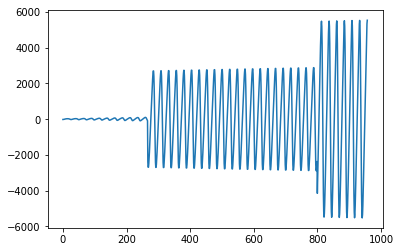

In [241]:
plot_coord_dif(0)

In [242]:
# размер ошибки по дельте времени
def plot_coord_dif_time(n):
    coord_dif = train[train['sat_id'] == n].loc[:, 'path'] - train[train['sat_id'] == n].loc[:, 'path_sim']
    passed_seconds = train[train['sat_id'] == n].loc[:, 'passed_seconds']
    plt.plot(passed_seconds, np.array(coord_dif))

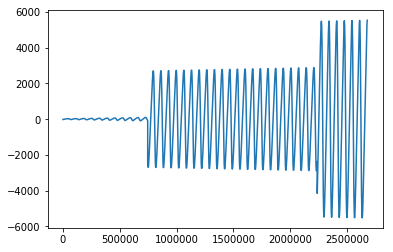

In [243]:
plot_coord_dif_time(0)

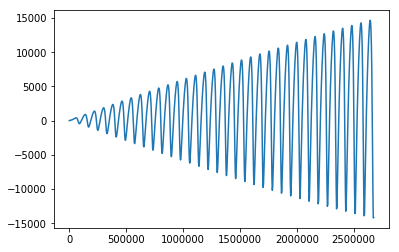

In [244]:
plot_coord_dif_time(333)

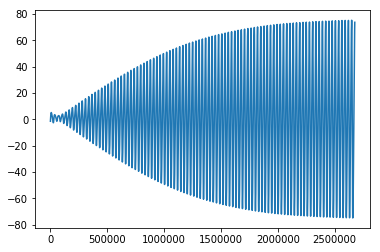

In [245]:
plot_coord_dif_time(444)

In [246]:
#===========================================================================

In [247]:
#===========================================================================

In [248]:
#===========================================================================

#### Стабильна ли скорость во времени 

In [249]:
train['V'] = np.sqrt(np.power(train.loc[:, 'Vx'],2) + 
                     np.power(train.loc[:, 'Vy'],2) + 
                     np.power(train.loc[:, 'Vz'],2)) 

In [250]:
train['V_sim'] = np.sqrt(np.power(train.loc[:, 'Vx_sim'],2) + 
                         np.power(train.loc[:, 'Vy_sim'],2) + 
                         np.power(train.loc[:, 'Vz_sim'],2)) 

In [251]:
test['V_sim'] = np.sqrt(np.power(test.loc[:, 'Vx_sim'],2) + 
                         np.power(test.loc[:, 'Vy_sim'],2) + 
                         np.power(test.loc[:, 'Vz_sim'],2)) 

In [252]:
train.loc[:, ['epoch','sat_id','V']].head(10)

,epoch,sat_id,V
0,2014-01-01T00:00:00.000,0,4.406588
1,2014-01-01T00:46:43.000,0,4.326931
2,2014-01-01T01:33:26.001,0,4.120966
3,2014-01-01T02:20:09.001,0,3.854871
4,2014-01-01T03:06:52.002,0,3.582143
5,2014-01-01T03:53:35.002,0,3.331210
6,2014-01-01T04:40:18.003,0,3.113272
7,2014-01-01T05:27:01.003,0,2.931178
8,2014-01-01T06:13:44.004,0,2.784557
9,2014-01-01T07:00:27.004,0,2.672147


In [253]:
train.loc[:, ['epoch','sat_id','V_sim']].head(10)

,epoch,sat_id,V_sim
0,2014-01-01T00:00:00.000,0,4.404340
1,2014-01-01T00:46:43.000,0,4.324766
2,2014-01-01T01:33:26.001,0,4.119305
3,2014-01-01T02:20:09.001,0,3.853846
4,2014-01-01T03:06:52.002,0,3.581697
5,2014-01-01T03:53:35.002,0,3.331236
6,2014-01-01T04:40:18.003,0,3.113676
7,2014-01-01T05:27:01.003,0,2.931893
8,2014-01-01T06:13:44.004,0,2.785534
9,2014-01-01T07:00:27.004,0,2.673353


In [254]:
def plot_V(n):
    plt.plot(list(train[train['sat_id'] == n].loc[:, 'passed_seconds']), list(train[train['sat_id'] == n].loc[:,'V']))

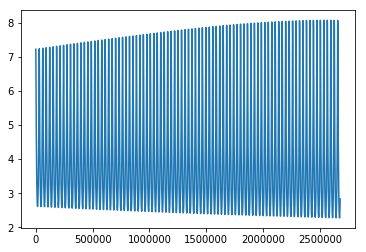

In [255]:
plot_V(1)

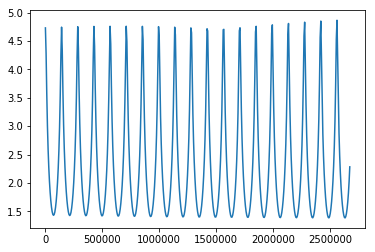

In [256]:
plot_V(100)

#### Признаки - прирост координат от скоростей по осям (Vx^2 / (Vx^2 + Vy^2 + Vz^2 )

In [257]:
train['Vx_gain'] = np.power(train.loc[:, 'Vx'],2) / (np.power(train.loc[:, 'Vx'],2) + np.power(train.loc[:, 'Vy'],2) + np.power(train.loc[:, 'Vz'],2))
train['Vy_gain'] = np.power(train.loc[:, 'Vy'],2) / (np.power(train.loc[:, 'Vx'],2) + np.power(train.loc[:, 'Vy'],2) + np.power(train.loc[:, 'Vz'],2))
train['Vz_gain'] = np.power(train.loc[:, 'Vz'],2) / (np.power(train.loc[:, 'Vx'],2) + np.power(train.loc[:, 'Vy'],2) + np.power(train.loc[:, 'Vz'],2))

In [258]:
train['Vx_sim_gain'] = np.power(train.loc[:, 'Vx_sim'],2) / (np.power(train.loc[:, 'Vx_sim'],2) + np.power(train.loc[:, 'Vy_sim'],2) + np.power(train.loc[:, 'Vz_sim'],2))
train['Vy_sim_gain'] = np.power(train.loc[:, 'Vy_sim'],2) / (np.power(train.loc[:, 'Vx_sim'],2) + np.power(train.loc[:, 'Vy_sim'],2) + np.power(train.loc[:, 'Vz_sim'],2))
train['Vz_sim_gain'] = np.power(train.loc[:, 'Vz_sim'],2) / (np.power(train.loc[:, 'Vx_sim'],2) + np.power(train.loc[:, 'Vy_sim'],2) + np.power(train.loc[:, 'Vz_sim'],2))

In [259]:
test['Vx_sim_gain'] = np.power(test.loc[:, 'Vx_sim'],2) / (np.power(test.loc[:, 'Vx_sim'],2) + np.power(test.loc[:, 'Vy_sim'],2) + np.power(test.loc[:, 'Vz_sim'],2))
test['Vy_sim_gain'] = np.power(test.loc[:, 'Vy_sim'],2) / (np.power(test.loc[:, 'Vx_sim'],2) + np.power(test.loc[:, 'Vy_sim'],2) + np.power(test.loc[:, 'Vz_sim'],2))
test['Vz_sim_gain'] = np.power(test.loc[:, 'Vz_sim'],2) / (np.power(test.loc[:, 'Vx_sim'],2) + np.power(test.loc[:, 'Vy_sim'],2) + np.power(test.loc[:, 'Vz_sim'],2))

In [260]:
train.loc[:, ['Vx', 'Vy', 'Vz', 'Vx_gain', 'Vy_gain', 'Vz_gain']].head()

,Vx,Vy,Vz,Vx_gain,Vy_gain,Vz_gain
0,-0.908303,-3.808436,-2.022083,0.042487,0.746945,0.210568
1,-0.302590,-4.272617,-0.612796,0.004890,0.975052,0.020057
2,0.277435,-4.047522,0.723155,0.004532,0.964674,0.030794
3,0.715600,-3.373762,1.722115,0.034460,0.765965,0.199574
4,0.992507,-2.519732,2.344703,0.076768,0.494792,0.428440


#### Признаки - высота орбиты в зависимости от скорости или координат

Approximately 63% of operational satellites are in low-Earth orbit, 6% are in medium-Earth orbit (at 20,000 km), 29% are in geostationary orbit (at 36,000 km) and the remaining 2% are in elliptic orbit.

https://www.physicsclassroom.com/class/circles/Lesson-4/Mathematics-of-Satellite-Motion

![title](speed_calculus.png)

Думаю будет корректно из этой формулы выразить R для каждого момента в наблюдениях

In [261]:
G = np.float64(6.673 / 10e10)
M = np.float64(5.98  * 10e23)
print(G)
print(M)

6.673e-11
5.98e+24


In [262]:
train.loc[:,['Vx_sim', 'Vy_sim', 'Vz_sim', 'V_sim']].head(3) # скорости у нас в км/с

,Vx_sim,Vy_sim,Vz_sim,V_sim
0,-0.907527,-3.804930,-2.024133,4.404340
1,-0.303704,-4.269816,-0.616468,4.324766
2,0.274880,-4.046788,0.718768,4.119305


In [263]:
train['Height'] =     (G*M/ (train.loc[:, 'V']*1000)**2)/1000
train['Height_sim'] = (G*M/ (train.loc[:, 'V_sim']*1000)**2)/1000
test['Height_sim']  = (G*M/ (test.loc[:, 'V_sim'] *1000)**2)/1000

Высоту еще можно расчитать по координатам

In [264]:
# находим гипотенузу между x и y, потом гипотенузу между результатом и z. Вычитаем 6371 потому что это радиус Земли
train['Height_coord'] =     np.sqrt( np.power( np.sqrt( np.power(train.loc[:,'x'],2) + np.power(train.loc[:,'y'],2)) ,2) + np.power(train.loc[:,'z'],2)) - 6371
train['Height_sim_coord'] = np.sqrt( np.power( np.sqrt( np.power(train.loc[:,'x_sim'],2) + np.power(train.loc[:,'y_sim'],2)) ,2) + np.power(train.loc[:,'z_sim'],2)) - 6371
test['Height_sim_coord'] =  np.sqrt( np.power( np.sqrt( np.power(test.loc[:,'x_sim'],2) + np.power(test.loc[:,'y_sim'],2)) ,2) + np.power(test.loc[:,'z_sim'],2)) - 6371

In [265]:
train.loc[:,'Height']

0         20550.266161
1         21313.870284
2         23497.642160
3         26853.604968
4         31098.282578
              ...     
649907    30214.210279
649908    27456.985779
649909    24623.933561
649910    21885.743026
649911    19402.911682
Name: Height, Length: 649912, dtype: float64

In [266]:
train.loc[:,'Height_coord']

0         19709.000000
1         20315.896582
2         21967.043990
3         24280.371610
4         26873.665434
              ...     
649907    20030.518338
649908    18919.803305
649909    17645.941319
649910    16263.565805
649911    14857.536717
Name: Height_coord, Length: 649912, dtype: float64

In [267]:
train.loc[:,'Height'].describe()

count    6.499120e+05
mean     4.444402e+04
std      5.913787e+04
min      2.464232e+03
25%      1.581908e+04
50%      2.564454e+04
75%      4.830457e+04
max      2.034055e+06
Name: Height, dtype: float64

In [268]:
train.loc[:,'Height_coord'].describe()

count    649912.000000
mean      26395.407027
std       25601.242972
min       -1720.153621
25%        9508.677133
50%       18127.563025
75%       34485.329791
max      287655.844052
Name: Height_coord, dtype: float64

Минимальное значение меньше 0 => какое-то фуфло

In [269]:
def plot_Height(n):
    plt.plot(list(train[train['sat_id'] == n].index), list(train[train['sat_id'] == n].loc[:,'Height']))

In [270]:
def plot_Height_coord(n):
    plt.plot(list(train[train['sat_id'] == n].index), list(train[train['sat_id'] == n].loc[:,'Height_coord']))

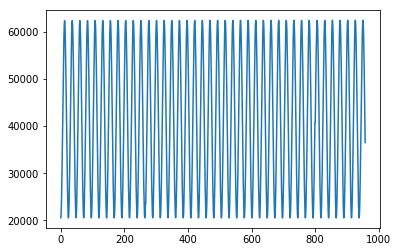

In [271]:
plot_Height(0)

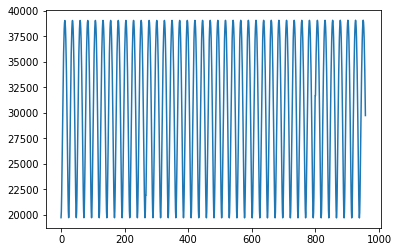

In [272]:
plot_Height_coord(0)

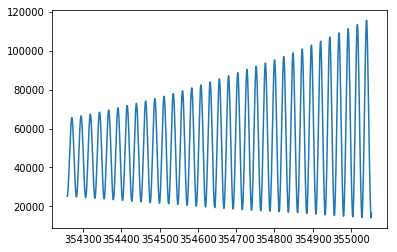

In [273]:
plot_Height(333)

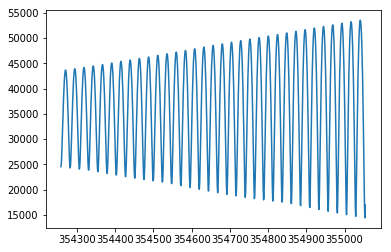

In [274]:
plot_Height_coord(333)

#### Признаки - углы alpha и fi

In [275]:
np.tan(1)

1.5574077246549023

In [276]:
np.degrees(np.arctan(np.tan(0.5)))

28.64788975654116

In [277]:
np.degrees(np.tan(np.sqrt(3)))

-352.2277045017174

In [278]:
np.arctan(np.sqrt(3))

1.0471975511965976

In [279]:
#===========================================================================

#### Признаки - эллиптичность орбиты

Эллиптичность рассчитывается как e = sqrt(pow(a,2)-pow(b,2)) / a

"a" - большая полуось; "b" - малая полуось; "е" - эксцентриситет эллипса

In [280]:
sat_data = pd.DataFrame(train.loc[:,'sat_id'].unique(), columns=['sat_id'])

In [281]:
sat_data.head(3)

,sat_id
0,0
1,1
2,2


In [282]:
sat_data['x_sim_max'] = train.loc[:, ['sat_id', 'x_sim']].groupby('sat_id').max()
sat_data['x_sim_min'] = train.loc[:, ['sat_id', 'x_sim']].groupby('sat_id').min()
sat_data['y_sim_max'] = train.loc[:, ['sat_id', 'y_sim']].groupby('sat_id').max()
sat_data['y_sim_min'] = train.loc[:, ['sat_id', 'y_sim']].groupby('sat_id').min()
sat_data['z_sim_max'] = train.loc[:, ['sat_id', 'z_sim']].groupby('sat_id').max()
sat_data['z_sim_min'] = train.loc[:, ['sat_id', 'z_sim']].groupby('sat_id').min()

In [283]:
sat_data.head(3)

,sat_id,x_sim_max,x_sim_min,y_sim_max,y_sim_min,z_sim_max,z_sim_min
0,0,17269.627379,-10663.078739,29891.530302,-39691.962101,40044.763219,-24477.716135
1,1,11199.853336,-30287.447717,19114.979309,-14496.096094,7119.621702,-12220.661191
2,2,34479.954736,-83304.837665,57453.564201,-36319.224115,36978.913464,-35513.924909


In [284]:
sat_data['x_sim_varience'] = sat_data.loc[:,'x_sim_max'] - sat_data.loc[:,'x_sim_min']
sat_data['y_sim_varience'] = sat_data.loc[:,'y_sim_max'] - sat_data.loc[:,'y_sim_min']
sat_data['z_sim_varience'] = sat_data.loc[:,'z_sim_max'] - sat_data.loc[:,'z_sim_min']

In [285]:
sat_data.head(3)

,sat_id,x_sim_max,x_sim_min,y_sim_max,y_sim_min,z_sim_max,z_sim_min,x_sim_varience,y_sim_varience,z_sim_varience
0,0,17269.627379,-10663.078739,29891.530302,-39691.962101,40044.763219,-24477.716135,27932.706118,69583.492403,64522.479354
1,1,11199.853336,-30287.447717,19114.979309,-14496.096094,7119.621702,-12220.661191,41487.301053,33611.075402,19340.282892
2,2,34479.954736,-83304.837665,57453.564201,-36319.224115,36978.913464,-35513.924909,117784.792401,93772.788316,72492.838373


Если я правильно понял, то большую полуось находим через оси с 2-мя максимальными вариативностями, а меньшую, через 1-ну максимальную и 1-ну минимальную

In [286]:
# ==============================================================================

#### Признаки - прирост по координате

In [287]:
np.cumsum(train.loc[:, 'x_sim'])

0        -8.843131e+03
1        -1.939863e+04
2        -2.997049e+04
3        -3.912011e+04
4        -4.584947e+04
              ...     
649907   -6.171387e+08
649908   -6.171614e+08
649909   -6.171848e+08
649910   -6.172077e+08
649911   -6.172284e+08
Name: x_sim, Length: 649912, dtype: float64

In [288]:
train.loc[:, 'path_sim']

0         26096.521772
1         26703.386480
2         28351.260474
3         30659.611188
4         33247.520541
              ...     
649907    26846.117535
649908    25823.419207
649909    24620.184851
649910    23280.546998
649911    21874.122209
Name: path_sim, Length: 649912, dtype: float64

In [289]:
# ==============================================================================

#### Ошибка по координатам от скорости

In [290]:
train.head(1)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,Vx_gain,Vy_gain,Vz_gain,Vx_sim_gain,Vy_sim_gain,Vz_sim_gain,Height,Height_sim,Height_coord,Height_sim_coord
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,0.042487,0.746945,0.210568,0.042458,0.746331,0.211211,20550.266161,20571.246894,19709.0,19725.521772


In [291]:
train['x_dif'] = train.loc[:, 'x'] - train.loc[:, 'x_sim']
train['y_dif'] = train.loc[:, 'y'] - train.loc[:, 'y_sim']
train['z_dif'] = train.loc[:, 'z'] - train.loc[:, 'z_sim']

train['Vx_dif'] = train.loc[:, 'Vx'] - train.loc[:, 'Vx_sim']
train['Vy_dif'] = train.loc[:, 'Vy'] - train.loc[:, 'Vy_sim']
train['Vz_dif'] = train.loc[:, 'Vz'] - train.loc[:, 'Vz_sim']

train.head(1)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,Height,Height_sim,Height_coord,Height_sim_coord,x_dif,y_dif,z_dif,Vx_dif,Vy_dif,Vz_dif
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,20550.266161,20571.246894,19709.0,19725.521772,-12.692409,-20.441543,13.262073,-0.000776,-0.003506,0.00205


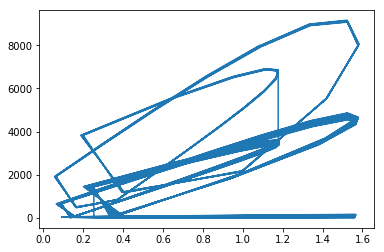

In [292]:
plt.plot(np.abs(train[train['sat_id']==0].loc[:, 'Vx']), np.abs(train[train['sat_id']==0].loc[:, 'x_dif']))

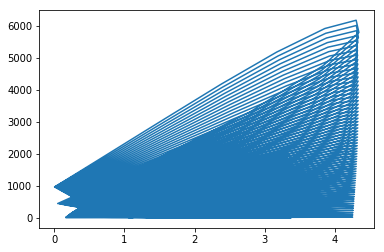

In [293]:
plt.plot(np.abs(train[train['sat_id']==111].loc[:, 'Vx']), np.abs(train[train['sat_id']==111].loc[:, 'x_dif']))

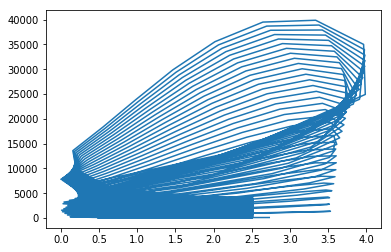

In [294]:
plt.plot(np.abs(train[train['sat_id']==333].loc[:, 'Vx']), np.abs(train[train['sat_id']==333].loc[:, 'x_dif']))

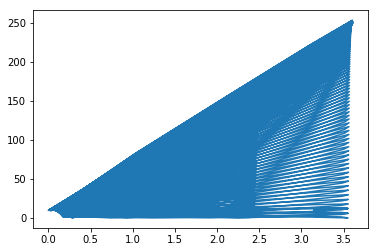

In [295]:
plt.plot(np.abs(train[train['sat_id']==444].loc[:, 'Vx']), np.abs(train[train['sat_id']==444].loc[:, 'x_dif']))

In [152]:
# ==============================================================================

## Если дороги ваши нервы, то дальше лучше не смотреть 

### Линейная модель 

In [110]:
y_train, y_test, X_train, X_test  = train_test_split(train.drop([ 'epoch', 'sat_id'], axis=1), 
                                                    train.drop([ 'epoch', 'sat_id'], axis=1),
                                                    train_size=0.7, test_size=0.3, random_state=1, shuffle=True)

переставлены y, Х, чтобы в у были реальные значения

In [111]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(454938, 38)
(454938, 38)
(194974, 38)
(194974, 38)


In [112]:
model_lin = LinearRegression()

model_lin.fit(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1), np.array(y_train.loc[:,'x']))

pred_lin_train =  model_lin.predict(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1))
pred_lin = model_lin.predict(np.array(X_test.loc[:,'x_sim']).reshape(-1, 1))

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim']).reshape(-1, 1)))

MAE pred train: 3365.99976533023
MAE pred: 3332.031462084599
MAE sim: 3089.196364769518


In [126]:
model_lin = LinearRegression()

model_lin.fit(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1), np.array(y_train.loc[:,'x']))

pred_lin_train =  model_lin.predict(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1))
pred_lin = model_lin.predict(np.array(X_test.loc[:,'x_sim']).reshape(-1, 1))

print('MAE pred train:', smape(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', smape(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', smape(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

MAE pred train: 0.18853702710404627
MAE pred: 0.18695780892287292
MAE sim: 0.18057031385023112


Вышло хуже симуляции, попробуем по-фану докинуть координаты другие и спиды :))) по осям

In [127]:
model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim','Vx_sim']], np.array(y_train.loc[:,'x']))
pred_lin = model_lin.predict(X_test.loc[:,['x_sim','Vx_sim']])

print('MAE pred:', smape(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', smape(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

MAE pred: 0.19516745309806305
MAE sim: 0.18057031385023112


In [128]:
model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']], np.array(y_train.loc[:,'x']))
pred_lin = model_lin.predict(X_test.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']])

print('MAE pred:', smape(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', smape(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

MAE pred: 0.1953309645579533
MAE sim: 0.18057031385023112


Еще хуже

Соберем сабамит из линейных моделей, чтобы сравнить с sample submission

In [245]:
# train_real = train_real.drop([ 'epoch', 'sat_id'], axis=1) 
# train_sim = train_sim.drop([ 'epoch', 'sat_id'], axis=1)

In [251]:
# model_lin = LinearRegression()

# model_lin.fit(np.array(train_sim.loc[:, 'x_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'x']))
# pred_x = model_lin.predict(np.array(test.loc[:, 'x_sim']).reshape(-1, 1))               

In [62]:
# model_lin.fit(np.array(train_sim.loc[:, 'y_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'y']))
# pred_y = model_lin.predict(np.array(test.loc[:, 'y_sim']).reshape(-1, 1))     

In [63]:
# model_lin.fit(np.array(train_sim.loc[:, 'z_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'z']))
# pred_z = model_lin.predict(np.array(test.loc[:, 'z_sim']).reshape(-1, 1))    

In [64]:
# model_lin.fit(np.array(train_sim.loc[:, 'Vx_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'Vx']))
# pred_Vx = model_lin.predict(np.array(test.loc[:, 'Vx_sim']).reshape(-1, 1))    

In [65]:
# model_lin.fit(np.array(train_sim.loc[:, 'Vy_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'Vy']))
# pred_Vy = model_lin.predict(np.array(test.loc[:, 'Vy_sim']).reshape(-1, 1))     

In [66]:
# model_lin.fit(np.array(train_sim.loc[:, 'Vz_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'Vz']))
# pred_Vz = model_lin.predict(np.array(test.loc[:, 'Vz_sim']).reshape(-1, 1))    

In [67]:
# submission_linear = pd.DataFrame({'id':test.loc[:,'id'], 'x':pred_x, 'y':pred_y, 'z':pred_z, 'Vx':pred_Vx, 'Vy':pred_Vy, 'Vz':pred_Vz})

In [68]:
# submission_linear.to_csv(r'D:\Загрузки\IDAO 2020\Track 1\submission_linear.csv', index=False)

Score :65.1 (baseline: 66.24)

In [115]:
model_lin.fit(train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']], train.loc[:,'x'])
pred_x = model_lin.predict(test.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']])

In [116]:
model_lin.fit(train.loc[:,['y_sim','Vy_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vy_sim_gain', 'Height_sim']], train.loc[:,'x'])
pred_y = model_lin.predict(test.loc[:,['y_sim','Vy_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vy_sim_gain', 'Height_sim']])

In [117]:
model_lin.fit(train.loc[:,['z_sim','Vz_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vz_sim_gain', 'Height_sim']], train.loc[:,'x'])
pred_z = model_lin.predict(test.loc[:,['z_sim','Vz_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vz_sim_gain', 'Height_sim']])

In [118]:
model_lin.fit(train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']], train.loc[:,'Vx'])
pred_Vx = model_lin.predict(test.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']])

In [119]:
model_lin.fit(train.loc[:,['y_sim','Vy_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vy_sim_gain', 'Height_sim']], train.loc[:,'Vy'])
pred_Vy = model_lin.predict(test.loc[:,['y_sim','Vy_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vy_sim_gain', 'Height_sim']])

In [120]:
model_lin.fit(train.loc[:,['z_sim','Vz_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vz_sim_gain', 'Height_sim']], train.loc[:,'Vz'])
pred_Vz = model_lin.predict(test.loc[:,['z_sim','Vz_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vz_sim_gain', 'Height_sim']])

In [121]:
submission_linear = pd.DataFrame({'id':test.loc[:,'id'], 'x':pred_x, 'y':pred_y, 'z':pred_z, 'Vx':pred_Vx, 'Vy':pred_Vy, 'Vz':pred_Vz})

In [266]:
submission_linear.to_csv(r'D:\Загрузки\IDAO 2020\Track 1\submission_linear.csv', index=False)

In [122]:
submission_linear.head(5)

,id,x,y,z,Vx,Vy,Vz
0,3927,-13490.021921,-427.946321,-1661.224105,3.691353,-0.625110,0.699964
1,3928,-7855.920379,-80.383322,-1153.200953,4.326777,0.263123,0.269190
2,3929,-1419.128668,49.899452,-388.992421,4.702616,1.664689,-0.466691
3,3930,5148.464067,-191.274797,668.721005,4.126464,3.645767,-1.609701
4,3931,9904.969493,-678.261916,1540.427239,1.638510,5.232703,-2.721053


Score :65.1 (baseline: 66.24)

### XGBRegression 

In [73]:
# model = xgb.XGBRegressor(booster='gblinear',
#                  colsample_bytree=0.4,
#                  gamma=0,                 
#                  learning_rate=0.07,
#                  max_depth=3,
#                  n_estimators=10000,                                                                    
#                  reg_alpha=0.75,
#                  reg_lambda=0.45,
#                  seed=1)

In [129]:
model = xgb.XGBRegressor(booster='gblinear')

model.fit(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1), np.array(y_train.loc[:,'x']))

pred_xgb = model.predict(np.array(X_test.loc[:,'x_sim']).reshape(-1, 1))
pred_xgb_train = model.predict(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1))

print('MAE pred train:', smape(np.array(y_train.loc[:,'x']), pred_xgb_train))
print('MAE pred:', smape(np.array(y_test.loc[:,'x']), pred_xgb))
print('MAE sim:', smape(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

[01:07:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE pred train: 0.18854083348153625
MAE pred: 0.18696117306404478
MAE sim: 0.18057031385023112


Почти то же самое, что и LinearRegression

#### Попробуем теперь линейную модель

In [221]:
y_train, y_test, X_train, X_test  = train_test_split(train.drop([ 'epoch', 'sat_id'], axis=1), 
                                                    train.drop([ 'epoch', 'sat_id'], axis=1),
                                                    train_size=0.7, test_size=0.3, random_state=1, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(454938, 30)
(454938, 30)
(194974, 30)
(194974, 30)


In [222]:
train.head(1)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,V,V_sim,Vx_gain,Vy_gain,Vz_gain,Vx_sim_gain,Vy_sim_gain,Vz_sim_gain,Height_sim,Height
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,4.406588,4.40434,0.042487,0.746945,0.210568,0.042458,0.746331,0.211211,20571.246894,20550.266161


In [223]:
model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim', 'passed_seconds']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim', 'passed_seconds']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim', 'passed_seconds']])

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

MAE pred train: 3365.7655160420095
MAE pred: 3331.52467359851
MAE sim: 3089.196364769518


ШтоШ, ничто не маешает затестить и свой монструозный ГБ

In [ ]:
model_lin = GradientBoostingRegressor(learning_rate=0.3, n_estimators=500)

model_lin.fit(X_train.loc[:,['x_sim', 'passed_seconds']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim', 'passed_seconds']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim', 'passed_seconds']])

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

Ничего не изменилось

In [225]:
model_lin = GradientBoostingRegressor(learning_rate=0.3, n_estimators=500)

model_lin.fit(X_train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']])

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

MAE pred train: 2972.8684050764073
MAE pred: 3019.090272219127
MAE sim: 3089.196364769518


Опять посмотрим на результат

In [131]:
y_train, y_test, X_train, X_test  = train_test_split(train.loc[:,['x','y','z','Vx','Vy','Vz', 'Vx_gain', 'Vy_gain', 'Vz_gain']], 
                                                    train.loc[:,['x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim','passed_seconds', 'Vx_sim_gain', 'Vy_sim_gain', 'Vz_sim_gain']],
                                                    train_size=0.7, test_size=0.3, random_state=1, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']])

print('MAE pred train:', smape(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', smape(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', smape(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

(454938, 10)
(454938, 9)
(194974, 10)
(194974, 9)
MAE pred train: 0.18832705947555503
MAE pred: 0.18676040373758274
MAE sim: 0.18057031385023112


Попробуем разбить без шаффла на отдельные спутники

In [130]:
ids = np.arange(0,600,1)
np.random.seed(1)
np.random.shuffle(ids)
train_ids, test_ids = ids[:500], ids[500:601]

y_train = train[train.loc[:,'sat_id'].isin(train_ids)].loc[:,['x','y','z','Vx','Vy','Vz']]
y_test =  train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,['x','y','z','Vx','Vy','Vz']] 
X_train = train[train.loc[:,'sat_id'].isin(train_ids)].drop(['x','y','z','Vx','Vy','Vz'], axis=1)
X_test =  train[train.loc[:,'sat_id'].isin(test_ids)].drop(['x','y','z','Vx','Vy','Vz'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']])

print('MAE pred train:', smape(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', smape(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', smape(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

(541958, 34)
(541958, 6)
(107954, 34)
(107954, 6)
MAE pred train: 0.19542308921106405
MAE pred: 0.19444738237134673
MAE sim: 0.18493416644787067


СВМ SVR - плохой результат

In [88]:
scaler = preprocessing.StandardScaler()
train_tmp = train.drop(['id', 'epoch', 'sat_id'], axis=1)
test_tmp = test.drop(['id', 'epoch', 'sat_id'], axis=1)
train_tmp = pd.DataFrame(scaler.fit_transform(train_tmp), columns = train_tmp.columns)
test_tmp = pd.DataFrame(scaler.fit_transform(test_tmp),  columns = test_tmp.columns)

train_tmp = pd.concat([train.loc[:,'sat_id'], train_tmp], axis=1)
test_tmp =  pd.concat([test.loc[:,'sat_id'], test_tmp], axis=1)

ids = np.arange(0,600,1)
np.random.seed(1)
np.random.shuffle(ids)
train_ids, test_ids = ids[:500], ids[500:601]

y_train = train_tmp[train_tmp.loc[:,'sat_id'].isin(train_ids)].loc[:,['x','y','z','Vx','Vy','Vz']]
y_test =  train_tmp[train_tmp.loc[:,'sat_id'].isin(test_ids)].loc[:,['x','y','z','Vx','Vy','Vz']] 
X_train = train_tmp[train_tmp.loc[:,'sat_id'].isin(train_ids)].drop(['x','y','z','Vx','Vy','Vz'], axis=1)
X_test =  train_tmp[train_tmp.loc[:,'sat_id'].isin(test_ids)].drop(['x','y','z','Vx','Vy','Vz'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model_lin = LinearSVR(random_state=1, max_iter=2000)

model_lin.fit(X_train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim']])

print('MAE pred train:', smape(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', smape(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', smape(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

(541958, 32)
(541958, 6)
(107954, 32)
(107954, 6)
MAE pred train: 0.17884356195026446
MAE pred: 0.18650946857433487
MAE sim: 0.18540021649156782


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [89]:
train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x']

8996      24439.156915
8997      36903.361280
8998      25330.707700
8999       7902.859437
9000     -10461.647376
              ...     
645009    -3321.024652
645010   -10325.340908
645011   -16807.962442
645012   -22523.061314
645013   -27288.711363
Name: x, Length: 107954, dtype: float64

In [90]:
scaler.fit_transform(np.array(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x']).reshape(-1, 1))

array([[ 0.97525236],
       [ 1.46021104],
       [ 1.00994092],
       ...,
       [-0.62959526],
       [-0.85195897],
       [-1.03738143]])

In [91]:
pred_lin[:5]

array([ 1.11258571,  1.47068558,  0.98563142,  0.30085352, -0.41428232])

In [92]:
pred_lin_unscaled = scaler.inverse_transform(pred_lin)
pred_lin_unscaled[:5]

array([ 27968.84117394,  37172.5734719 ,  24705.91516525,   7106.04129796,
       -11274.07986724])

In [93]:
pd.Series(pred_lin_unscaled)

0         27968.841174
1         37172.573472
2         24705.915165
3          7106.041298
4        -11274.079867
              ...     
107949    -2207.917378
107950    -9334.527380
107951   -15971.219727
107952   -21861.123004
107953   -26815.323679
Length: 107954, dtype: float64

In [94]:
print('MAE pred:', mean_absolute_error(np.array(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x']), pred_lin_unscaled))
print('MAE pred:', mean_absolute_error(np.array(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x']), np.array(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x_sim'])))

MAE pred: 3449.369646981867
MAE pred: 3359.827842431769


In [95]:
print('MAE pred:', mean_absolute_error(np.array(train.loc[:,'x']), np.array(train.loc[:,'x_sim'])))

MAE pred: 3113.873308007775


In [96]:
train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x']

8996      24439.156915
8997      36903.361280
8998      25330.707700
8999       7902.859437
9000     -10461.647376
              ...     
645009    -3321.024652
645010   -10325.340908
645011   -16807.962442
645012   -22523.061314
645013   -27288.711363
Name: x, Length: 107954, dtype: float64

In [97]:
train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x_sim']

8996      27274.647776
8997      36625.418859
8998      24388.765323
8999       7017.252693
9000     -11147.186870
              ...     
645009    -2097.226576
645010    -9154.093490
645011   -15741.136438
645012   -21600.522604
645013   -26542.296616
Name: x_sim, Length: 107954, dtype: float64

In [98]:
pd.Series(pred_lin_unscaled)

0         27968.841174
1         37172.573472
2         24705.915165
3          7106.041298
4        -11274.079867
              ...     
107949    -2207.917378
107950    -9334.527380
107951   -15971.219727
107952   -21861.123004
107953   -26815.323679
Length: 107954, dtype: float64

Как ни странно сумма ошибок между реальными и предиктами меньше, чем у симуляции

In [99]:
np.sum(np.abs(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x'] - train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x_sim']))

362706854.9018792

In [100]:
np.sum(np.abs(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x'] - pd.Series(pred_lin_unscaled)))

343618840.57733536

### CatBoostRegressor 

In [296]:
ids = np.arange(0,600,1)
np.random.seed(1)
np.random.shuffle(ids)
train_ids, test_ids = ids[:500], ids[500:601]

y_train = train[train.loc[:,'sat_id'].isin(train_ids)].loc[:,['x','y','z','Vx','Vy','Vz']]
y_test =  train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,['x','y','z','Vx','Vy','Vz']] 
X_train = train[train.loc[:,'sat_id'].isin(train_ids)].drop(['x','y','z','Vx','Vy','Vz'], axis=1)
X_test =  train[train.loc[:,'sat_id'].isin(test_ids)].drop(['x','y','z','Vx','Vy','Vz'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(541958, 34)
(541958, 6)
(107954, 34)
(107954, 6)


In [307]:
model_lin = CatBoostRegressor(iterations=200, learning_rate=0.5, loss_function='MAE', random_seed=1)

model_lin.fit(train.loc[:, ['x_sim', 'passed_seconds', 'Height_sim_coord']], np.array(train.loc[:, 'x']))
pred_x = model_lin.predict(test.loc[:, ['x_sim', 'passed_seconds', 'Height_sim_coord']])               

0:	learn: 12045.2513706	total: 90.5ms	remaining: 18s
1:	learn: 9479.4206038	total: 170ms	remaining: 16.8s
2:	learn: 7982.0042282	total: 249ms	remaining: 16.4s
3:	learn: 6863.1101782	total: 333ms	remaining: 16.3s
4:	learn: 5948.1807075	total: 415ms	remaining: 16.2s
5:	learn: 5251.7636581	total: 497ms	remaining: 16.1s
6:	learn: 4780.7206977	total: 582ms	remaining: 16s
7:	learn: 4477.3733671	total: 666ms	remaining: 16s
8:	learn: 4220.6142906	total: 755ms	remaining: 16s
9:	learn: 4020.8402178	total: 847ms	remaining: 16.1s
10:	learn: 3872.6990681	total: 941ms	remaining: 16.2s
11:	learn: 3752.0185924	total: 1.03s	remaining: 16.1s
12:	learn: 3693.0782908	total: 1.13s	remaining: 16.2s
13:	learn: 3650.6346620	total: 1.21s	remaining: 16.1s
14:	learn: 3612.1379642	total: 1.3s	remaining: 16.1s
15:	learn: 3588.2543842	total: 1.4s	remaining: 16.1s
16:	learn: 3538.8576890	total: 1.5s	remaining: 16.1s
17:	learn: 3521.4979771	total: 1.59s	remaining: 16s
18:	learn: 3512.9135338	total: 1.67s	remaining: 1

154:	learn: 3123.8508685	total: 14.3s	remaining: 4.15s
155:	learn: 3123.3702634	total: 14.4s	remaining: 4.05s
156:	learn: 3122.6963949	total: 14.5s	remaining: 3.96s
157:	learn: 3122.2832388	total: 14.6s	remaining: 3.87s
158:	learn: 3121.9262819	total: 14.7s	remaining: 3.78s
159:	learn: 3120.0969875	total: 14.8s	remaining: 3.69s
160:	learn: 3118.7497671	total: 14.8s	remaining: 3.6s
161:	learn: 3117.3520273	total: 14.9s	remaining: 3.5s
162:	learn: 3116.3039039	total: 15s	remaining: 3.41s
163:	learn: 3115.2016408	total: 15.1s	remaining: 3.32s
164:	learn: 3114.7196996	total: 15.2s	remaining: 3.23s
165:	learn: 3114.3945170	total: 15.3s	remaining: 3.13s
166:	learn: 3113.7444688	total: 15.4s	remaining: 3.04s
167:	learn: 3113.4216534	total: 15.5s	remaining: 2.95s
168:	learn: 3112.8430620	total: 15.6s	remaining: 2.86s
169:	learn: 3112.4024774	total: 15.7s	remaining: 2.77s
170:	learn: 3111.6000455	total: 15.8s	remaining: 2.67s
171:	learn: 3110.4076891	total: 15.9s	remaining: 2.58s
172:	learn: 31

In [309]:
model_lin.fit(train_sim.loc[:, ['y_sim', 'passed_seconds', 'Height_sim_coord']], np.array(train.loc[:, 'y']))
pred_y = model_lin.predict(test.loc[:, ['y_sim', 'passed_seconds', 'Height_sim_coord']])     

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


0:	learn: 11623.0617784	total: 94.8ms	remaining: 18.9s
1:	learn: 9075.1764427	total: 182ms	remaining: 18s
2:	learn: 7638.3972633	total: 262ms	remaining: 17.2s
3:	learn: 6670.8628134	total: 348ms	remaining: 17.1s
4:	learn: 5812.2117873	total: 434ms	remaining: 16.9s
5:	learn: 5203.7210213	total: 519ms	remaining: 16.8s
6:	learn: 4709.5287242	total: 609ms	remaining: 16.8s
7:	learn: 4349.2350452	total: 695ms	remaining: 16.7s
8:	learn: 4065.1233524	total: 780ms	remaining: 16.6s
9:	learn: 3872.1597550	total: 874ms	remaining: 16.6s
10:	learn: 3742.0317088	total: 961ms	remaining: 16.5s
11:	learn: 3668.0141736	total: 1.05s	remaining: 16.5s
12:	learn: 3648.6081238	total: 1.15s	remaining: 16.6s
13:	learn: 3628.7906623	total: 1.24s	remaining: 16.5s
14:	learn: 3606.8657973	total: 1.34s	remaining: 16.6s
15:	learn: 3592.0139452	total: 1.43s	remaining: 16.5s
16:	learn: 3568.2743642	total: 1.53s	remaining: 16.5s
17:	learn: 3554.6523414	total: 1.63s	remaining: 16.5s
18:	learn: 3536.5819067	total: 1.73s	r

153:	learn: 3314.7329960	total: 15.3s	remaining: 4.58s
154:	learn: 3314.7216568	total: 15.4s	remaining: 4.47s
155:	learn: 3314.7017611	total: 15.5s	remaining: 4.38s
156:	learn: 3314.6693305	total: 15.6s	remaining: 4.28s
157:	learn: 3314.6622743	total: 15.7s	remaining: 4.18s
158:	learn: 3314.6522817	total: 15.8s	remaining: 4.08s
159:	learn: 3314.6361609	total: 15.9s	remaining: 3.98s
160:	learn: 3314.6202478	total: 16s	remaining: 3.88s
161:	learn: 3314.5589983	total: 16.1s	remaining: 3.78s
162:	learn: 3314.5504371	total: 16.2s	remaining: 3.68s
163:	learn: 3314.5463088	total: 16.3s	remaining: 3.58s
164:	learn: 3314.4886658	total: 16.4s	remaining: 3.48s
165:	learn: 3314.4687798	total: 16.5s	remaining: 3.38s
166:	learn: 3314.4578642	total: 16.6s	remaining: 3.28s
167:	learn: 3314.4453838	total: 16.7s	remaining: 3.18s
168:	learn: 3314.4424158	total: 16.8s	remaining: 3.08s
169:	learn: 3314.4232623	total: 16.9s	remaining: 2.98s
170:	learn: 3314.4171335	total: 17s	remaining: 2.88s
171:	learn: 33

In [310]:
model_lin.fit(train.loc[:, ['z_sim', 'passed_seconds', 'Height_sim_coord']], np.array(train.loc[:, 'z']))
pred_z = model_lin.predict(test.loc[:, ['z_sim', 'passed_seconds', 'Height_sim_coord']])    

0:	learn: 9247.4660687	total: 88.4ms	remaining: 17.6s
1:	learn: 7503.7540067	total: 173ms	remaining: 17.1s
2:	learn: 6318.2731110	total: 255ms	remaining: 16.7s
3:	learn: 5412.9886672	total: 341ms	remaining: 16.7s
4:	learn: 4689.5473809	total: 425ms	remaining: 16.6s
5:	learn: 4197.3803928	total: 511ms	remaining: 16.5s
6:	learn: 3803.4368131	total: 601ms	remaining: 16.6s
7:	learn: 3495.9757759	total: 691ms	remaining: 16.6s
8:	learn: 3247.6351657	total: 776ms	remaining: 16.5s
9:	learn: 3111.1731031	total: 870ms	remaining: 16.5s
10:	learn: 3006.6761678	total: 958ms	remaining: 16.5s
11:	learn: 2901.7686602	total: 1.05s	remaining: 16.4s
12:	learn: 2844.3443489	total: 1.13s	remaining: 16.3s
13:	learn: 2817.8231320	total: 1.22s	remaining: 16.3s
14:	learn: 2790.1425716	total: 1.31s	remaining: 16.2s
15:	learn: 2762.7090864	total: 1.4s	remaining: 16.2s
16:	learn: 2751.2205948	total: 1.5s	remaining: 16.1s
17:	learn: 2722.3475568	total: 1.59s	remaining: 16.1s
18:	learn: 2714.9193669	total: 1.68s	re

154:	learn: 2349.1565958	total: 14.3s	remaining: 4.16s
155:	learn: 2348.0288132	total: 14.4s	remaining: 4.07s
156:	learn: 2347.7461920	total: 14.5s	remaining: 3.97s
157:	learn: 2347.4335879	total: 14.6s	remaining: 3.88s
158:	learn: 2346.5793377	total: 14.7s	remaining: 3.79s
159:	learn: 2345.2787157	total: 14.8s	remaining: 3.69s
160:	learn: 2344.9033430	total: 14.9s	remaining: 3.6s
161:	learn: 2344.6327134	total: 15s	remaining: 3.51s
162:	learn: 2344.0770835	total: 15.1s	remaining: 3.42s
163:	learn: 2342.8114580	total: 15.2s	remaining: 3.33s
164:	learn: 2342.4208254	total: 15.2s	remaining: 3.23s
165:	learn: 2342.1733118	total: 15.3s	remaining: 3.14s
166:	learn: 2341.6747121	total: 15.4s	remaining: 3.05s
167:	learn: 2339.2622445	total: 15.5s	remaining: 2.95s
168:	learn: 2337.7358090	total: 15.6s	remaining: 2.86s
169:	learn: 2335.4134215	total: 15.7s	remaining: 2.77s
170:	learn: 2335.2310743	total: 15.8s	remaining: 2.67s
171:	learn: 2334.6413127	total: 15.9s	remaining: 2.58s
172:	learn: 2

In [314]:
model_lin.fit(train_sim.loc[:, ['Vx_sim', 'V_sim', 'Vx_sim_gain', 'passed_seconds', 'Height_sim_coord', 'Height_sim']], train.loc[:, 'Vx'])
pred_Vx = model_lin.predict(test.loc[:, ['Vx_sim', 'V_sim', 'Vx_sim_gain', 'passed_seconds', 'Height_sim_coord', 'Height_sim']])  

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


0:	learn: 1.4191342	total: 95.9ms	remaining: 19.1s
1:	learn: 1.0423374	total: 184ms	remaining: 18.2s
2:	learn: 0.8859371	total: 269ms	remaining: 17.6s
3:	learn: 0.7948663	total: 367ms	remaining: 18s
4:	learn: 0.7338858	total: 450ms	remaining: 17.5s
5:	learn: 0.6969635	total: 540ms	remaining: 17.4s
6:	learn: 0.6732045	total: 625ms	remaining: 17.2s
7:	learn: 0.6598929	total: 715ms	remaining: 17.2s
8:	learn: 0.6522553	total: 807ms	remaining: 17.1s
9:	learn: 0.6473964	total: 893ms	remaining: 17s
10:	learn: 0.6450276	total: 979ms	remaining: 16.8s
11:	learn: 0.6433773	total: 1.07s	remaining: 16.7s
12:	learn: 0.6414466	total: 1.16s	remaining: 16.7s
13:	learn: 0.6390711	total: 1.25s	remaining: 16.6s
14:	learn: 0.6356591	total: 1.36s	remaining: 16.8s
15:	learn: 0.6336582	total: 1.45s	remaining: 16.7s
16:	learn: 0.6328576	total: 1.54s	remaining: 16.6s
17:	learn: 0.6319846	total: 1.63s	remaining: 16.5s
18:	learn: 0.6296643	total: 1.73s	remaining: 16.5s
19:	learn: 0.6290647	total: 1.82s	remaining:

162:	learn: 0.6156644	total: 15.8s	remaining: 3.6s
163:	learn: 0.6156632	total: 15.9s	remaining: 3.5s
164:	learn: 0.6156609	total: 16s	remaining: 3.4s
165:	learn: 0.6156591	total: 16.1s	remaining: 3.3s
166:	learn: 0.6156585	total: 16.2s	remaining: 3.2s
167:	learn: 0.6156575	total: 16.3s	remaining: 3.11s
168:	learn: 0.6156567	total: 16.4s	remaining: 3.01s
169:	learn: 0.6156562	total: 16.5s	remaining: 2.91s
170:	learn: 0.6156554	total: 16.6s	remaining: 2.81s
171:	learn: 0.6156540	total: 16.7s	remaining: 2.72s
172:	learn: 0.6156529	total: 16.8s	remaining: 2.62s
173:	learn: 0.6156486	total: 16.9s	remaining: 2.52s
174:	learn: 0.6156478	total: 17s	remaining: 2.43s
175:	learn: 0.6156473	total: 17.1s	remaining: 2.33s
176:	learn: 0.6156463	total: 17.2s	remaining: 2.23s
177:	learn: 0.6156432	total: 17.3s	remaining: 2.14s
178:	learn: 0.6156427	total: 17.4s	remaining: 2.04s
179:	learn: 0.6156405	total: 17.5s	remaining: 1.94s
180:	learn: 0.6156395	total: 17.6s	remaining: 1.84s
181:	learn: 0.6156381

In [315]:
model_lin.fit(train_sim.loc[:, ['Vy_sim', 'V_sim', 'Vy_sim_gain', 'passed_seconds', 'Height_sim_coord', 'Height_sim']], train.loc[:, 'Vy'])
pred_Vy = model_lin.predict(test.loc[:, ['Vy_sim', 'V_sim', 'Vy_sim_gain', 'passed_seconds', 'Height_sim_coord', 'Height_sim']])  

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


0:	learn: 1.3990782	total: 96.2ms	remaining: 19.2s
1:	learn: 1.0460773	total: 181ms	remaining: 17.9s
2:	learn: 0.8970425	total: 267ms	remaining: 17.5s
3:	learn: 0.7989238	total: 363ms	remaining: 17.8s
4:	learn: 0.7417692	total: 475ms	remaining: 18.5s
5:	learn: 0.7018901	total: 563ms	remaining: 18.2s
6:	learn: 0.6766912	total: 652ms	remaining: 18s
7:	learn: 0.6623643	total: 740ms	remaining: 17.8s
8:	learn: 0.6535068	total: 838ms	remaining: 17.8s
9:	learn: 0.6474460	total: 928ms	remaining: 17.6s
10:	learn: 0.6437909	total: 1.02s	remaining: 17.5s
11:	learn: 0.6406670	total: 1.11s	remaining: 17.4s
12:	learn: 0.6386729	total: 1.2s	remaining: 17.3s
13:	learn: 0.6371063	total: 1.29s	remaining: 17.2s
14:	learn: 0.6357197	total: 1.4s	remaining: 17.2s
15:	learn: 0.6348812	total: 1.49s	remaining: 17.1s
16:	learn: 0.6336167	total: 1.58s	remaining: 17s
17:	learn: 0.6327765	total: 1.68s	remaining: 17s
18:	learn: 0.6317844	total: 1.77s	remaining: 16.9s
19:	learn: 0.6308583	total: 1.87s	remaining: 16.

161:	learn: 0.6179359	total: 15.8s	remaining: 3.69s
162:	learn: 0.6179351	total: 15.8s	remaining: 3.6s
163:	learn: 0.6179346	total: 15.9s	remaining: 3.5s
164:	learn: 0.6179332	total: 16s	remaining: 3.4s
165:	learn: 0.6179320	total: 16.1s	remaining: 3.3s
166:	learn: 0.6179314	total: 16.2s	remaining: 3.21s
167:	learn: 0.6179305	total: 16.3s	remaining: 3.11s
168:	learn: 0.6179294	total: 16.4s	remaining: 3.01s
169:	learn: 0.6179254	total: 16.5s	remaining: 2.92s
170:	learn: 0.6179239	total: 16.6s	remaining: 2.82s
171:	learn: 0.6179236	total: 16.7s	remaining: 2.72s
172:	learn: 0.6179224	total: 16.8s	remaining: 2.62s
173:	learn: 0.6179214	total: 16.9s	remaining: 2.52s
174:	learn: 0.6179209	total: 17s	remaining: 2.43s
175:	learn: 0.6179196	total: 17.1s	remaining: 2.33s
176:	learn: 0.6179192	total: 17.2s	remaining: 2.23s
177:	learn: 0.6179182	total: 17.3s	remaining: 2.13s
178:	learn: 0.6179158	total: 17.4s	remaining: 2.04s
179:	learn: 0.6179154	total: 17.4s	remaining: 1.94s
180:	learn: 0.617914

In [316]:
model_lin.fit(train_sim.loc[:, ['Vz_sim', 'V_sim', 'Vz_sim_gain', 'passed_seconds', 'Height_sim_coord', 'Height_sim']], train.loc[:, 'Vz'])
pred_Vz = model_lin.predict(test.loc[:, ['Vz_sim', 'V_sim', 'Vz_sim_gain', 'passed_seconds', 'Height_sim_coord', 'Height_sim']])  

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


0:	learn: 1.1307919	total: 96.4ms	remaining: 19.2s
1:	learn: 0.9023767	total: 183ms	remaining: 18.1s
2:	learn: 0.7611054	total: 270ms	remaining: 17.7s
3:	learn: 0.6690208	total: 359ms	remaining: 17.6s
4:	learn: 0.6091383	total: 452ms	remaining: 17.6s
5:	learn: 0.5734088	total: 541ms	remaining: 17.5s
6:	learn: 0.5510372	total: 635ms	remaining: 17.5s
7:	learn: 0.5362637	total: 725ms	remaining: 17.4s
8:	learn: 0.5252329	total: 822ms	remaining: 17.4s
9:	learn: 0.5156044	total: 932ms	remaining: 17.7s
10:	learn: 0.5094974	total: 1.03s	remaining: 17.6s
11:	learn: 0.5047581	total: 1.12s	remaining: 17.5s
12:	learn: 0.5028786	total: 1.21s	remaining: 17.5s
13:	learn: 0.5016986	total: 1.31s	remaining: 17.4s
14:	learn: 0.4997827	total: 1.4s	remaining: 17.3s
15:	learn: 0.4974141	total: 1.49s	remaining: 17.2s
16:	learn: 0.4953683	total: 1.59s	remaining: 17.1s
17:	learn: 0.4933015	total: 1.68s	remaining: 17s
18:	learn: 0.4921824	total: 1.78s	remaining: 16.9s
19:	learn: 0.4914380	total: 1.87s	remaining

161:	learn: 0.4784191	total: 16.2s	remaining: 3.79s
162:	learn: 0.4784185	total: 16.3s	remaining: 3.69s
163:	learn: 0.4784167	total: 16.4s	remaining: 3.59s
164:	learn: 0.4784161	total: 16.5s	remaining: 3.49s
165:	learn: 0.4784157	total: 16.6s	remaining: 3.39s
166:	learn: 0.4784152	total: 16.7s	remaining: 3.29s
167:	learn: 0.4784141	total: 16.8s	remaining: 3.19s
168:	learn: 0.4784107	total: 16.9s	remaining: 3.09s
169:	learn: 0.4784098	total: 17s	remaining: 2.99s
170:	learn: 0.4784092	total: 17.1s	remaining: 2.89s
171:	learn: 0.4784088	total: 17.1s	remaining: 2.79s
172:	learn: 0.4784083	total: 17.2s	remaining: 2.69s
173:	learn: 0.4784065	total: 17.3s	remaining: 2.59s
174:	learn: 0.4784061	total: 17.4s	remaining: 2.49s
175:	learn: 0.4784043	total: 17.5s	remaining: 2.39s
176:	learn: 0.4784038	total: 17.6s	remaining: 2.29s
177:	learn: 0.4784009	total: 17.7s	remaining: 2.19s
178:	learn: 0.4783998	total: 17.8s	remaining: 2.09s
179:	learn: 0.4783989	total: 17.9s	remaining: 1.99s
180:	learn: 0.

In [317]:
submission_cat_dummy = pd.DataFrame({'id':test.loc[:,'id'], 'x':pred_x, 'y':pred_y, 'z':pred_z, 'Vx':pred_Vx, 'Vy':pred_Vy, 'Vz':pred_Vz})

In [318]:
submission_cat_dummy.to_csv(r'D:\Загрузки\IDAO 2020\Track 1\submission_cat_dummy.csv', index=False)

In [185]:
train.columns

Index(['id', 'epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim',
       'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim', 'day', 'hour', 'minute',
       'second', 'passed_seconds', 'V', 'V_sim', 'Vx_gain', 'Vy_gain',
       'Vz_gain', 'Vx_sim_gain', 'Vy_sim_gain', 'Vz_sim_gain', 'Height',
       'Height_sim', 'Height_coord', 'Height_sim_coord', 'x_dif', 'y_dif',
       'z_dif', 'Vx_dif', 'Vy_dif', 'Vz_dif'],
      dtype='object')

In [199]:
model = CatBoostRegressor(iterations=100, learning_rate=0.12, depth=4, loss_function='MAE', random_seed=1, reg_lambda=0.1)

In [187]:
model.fit(X_train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim', 'Height_sim_coord']], y_train.loc[:,'x'], 
          eval_set=(X_test.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim', 'Height_sim_coord']],y_test.loc[:,'x']))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


0:	learn: 16356.8699614	test: 16032.5871812	best: 16032.5871812 (0)	total: 70.4ms	remaining: 6.97s
1:	learn: 15139.3382407	test: 14873.5913895	best: 14873.5913895 (1)	total: 134ms	remaining: 6.57s
2:	learn: 14104.9744466	test: 13886.1708747	best: 13886.1708747 (2)	total: 200ms	remaining: 6.47s
3:	learn: 13218.1635817	test: 13041.2035868	best: 13041.2035868 (3)	total: 264ms	remaining: 6.34s
4:	learn: 12450.2624485	test: 12299.8253235	best: 12299.8253235 (4)	total: 335ms	remaining: 6.36s
5:	learn: 11725.6760010	test: 11613.1612418	best: 11613.1612418 (5)	total: 396ms	remaining: 6.21s
6:	learn: 10955.7672789	test: 10892.4210708	best: 10892.4210708 (6)	total: 459ms	remaining: 6.1s
7:	learn: 10358.6539493	test: 10329.7656347	best: 10329.7656347 (7)	total: 530ms	remaining: 6.1s
8:	learn: 9882.2223602	test: 9865.9625234	best: 9865.9625234 (8)	total: 597ms	remaining: 6.04s
9:	learn: 9339.8134507	test: 9386.7025369	best: 9386.7025369 (9)	total: 664ms	remaining: 5.98s
10:	learn: 8898.4983620	tes

88:	learn: 3231.1091378	test: 3701.3660467	best: 3701.3660467 (88)	total: 6.14s	remaining: 759ms
89:	learn: 3230.5908046	test: 3701.2249649	best: 3701.2249649 (89)	total: 6.21s	remaining: 690ms
90:	learn: 3229.5260628	test: 3701.3629551	best: 3701.2249649 (89)	total: 6.27s	remaining: 621ms
91:	learn: 3228.4595463	test: 3701.2670958	best: 3701.2249649 (89)	total: 6.34s	remaining: 551ms
92:	learn: 3227.4663674	test: 3699.6733877	best: 3699.6733877 (92)	total: 6.41s	remaining: 482ms
93:	learn: 3225.5265414	test: 3699.9888976	best: 3699.6733877 (92)	total: 6.47s	remaining: 413ms
94:	learn: 3223.3910894	test: 3697.3452337	best: 3697.3452337 (94)	total: 6.55s	remaining: 345ms
95:	learn: 3222.8068821	test: 3696.8663131	best: 3696.8663131 (95)	total: 6.62s	remaining: 276ms
96:	learn: 3222.0928009	test: 3696.4408950	best: 3696.4408950 (96)	total: 6.68s	remaining: 207ms
97:	learn: 3221.2184106	test: 3696.6687879	best: 3696.4408950 (96)	total: 6.75s	remaining: 138ms
98:	learn: 3220.2102229	test: 

In [188]:
pred_train =  model.predict(X_train.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim', 'Height_sim_coord']])
pred = model.predict(X_test.loc[:,['x_sim','Vx_sim', 'passed_seconds', 'path_sim', 'V_sim', 'Vx_sim_gain', 'Height_sim', 'Height_sim_coord']])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [189]:
print('smape pred train:', smape(np.array(y_train.loc[:,'x']), pred_train))
print('smape pred:', smape(np.array(y_test.loc[:,'x']), pred))
print('smape sim:', smape(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

smape pred train: 0.18290523051239393
smape pred: 0.20179789156975034
smape sim: 0.18493416644787067


In [190]:
print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

MAE pred train: 3222.0928018953896
MAE pred: 3696.4408989254653
MAE sim: 3359.827842431769


In [191]:
np.sum(np.abs(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x'] - pd.Series(pred)))

339700649.7586325